### Problem Statement

The mushrooms dataset contains details about different mushroom types. The aim is to determine whether a mushroom is of class `e` = edible, or class `p` = poisonous.

For more information on the data within the CSV, see the data dictionary.

### Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import Counter
import scipy.stats as ss
from itertools import product
from sklearn import tree
from sklearn.model_selection import train_test_split
import graphviz
from sklearn import metrics

pd.options.display.max_columns = None

### Import Data

In [2]:
df = pd.read_csv('mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [3]:
print(f'number of records: {len(df)}')
print(f'number of columns: {len(df.columns)}')

number of records: 8124
number of columns: 23


### Exploratory Data Analysis

In [4]:
df.dtypes

class                       object
cap-shape                   object
cap-surface                 object
cap-color                   object
bruises                     object
odor                        object
gill-attachment             object
gill-spacing                object
gill-size                   object
gill-color                  object
stalk-shape                 object
stalk-root                  object
stalk-surface-above-ring    object
stalk-surface-below-ring    object
stalk-color-above-ring      object
stalk-color-below-ring      object
veil-type                   object
veil-color                  object
ring-number                 object
ring-type                   object
spore-print-color           object
population                  object
habitat                     object
dtype: object

In [5]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [6]:
for col in df.columns:
    print(col) if df['class'].str.isnumeric().sum()>0 else next

Every single feature is categorical and defined by a letter. These will need to be one-hot encoded later in the process.

Dropping veil-type as it only contains one value so will not provide any information.

In [7]:
df.drop(columns=['veil-type'],inplace=True)

In [8]:
df['class'].value_counts() / len(df)

e    0.517971
p    0.482029
Name: class, dtype: float64

The dataset has two classes and is pretty much balanced 50/50 so I won't need to explore any sampling techniques to correct any imbalance.

In [9]:
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

No missing values so nothing to deal with there.

In [10]:
model_data = df.copy()

In [11]:
model_data['target'] = np.where(model_data['class']=='p'
                               ,1
                               ,0)

In [12]:
model_data = pd.get_dummies(model_data.drop(columns='class'))

In [13]:
model_data.columns

Index(['target', 'cap-shape_b', 'cap-shape_c', 'cap-shape_f', 'cap-shape_k',
       'cap-shape_s', 'cap-shape_x', 'cap-surface_f', 'cap-surface_g',
       'cap-surface_s',
       ...
       'population_s', 'population_v', 'population_y', 'habitat_d',
       'habitat_g', 'habitat_l', 'habitat_m', 'habitat_p', 'habitat_u',
       'habitat_w'],
      dtype='object', length=117)

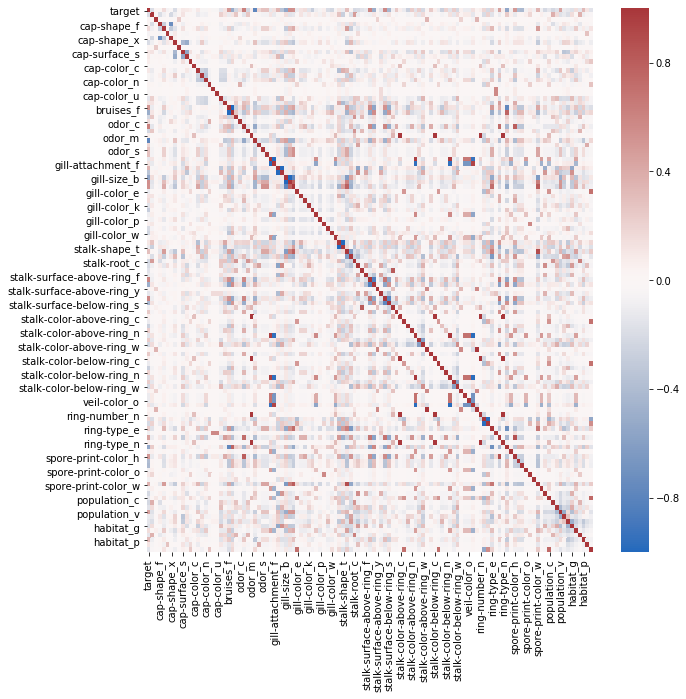

In [14]:
co = model_data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(co, cmap="vlag")

The heatmap showing the correlation of the encoded variables with the target is really difficult to interpret.

Borrowing the code from [this post](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9), we can view the relationships between the variables using Theil's U. The output values range from 0 to 1, where 0 means no association and 1 is full association.

In [15]:
def conditional_entropy(x,
                        y,
                        log_base: float = math.e):
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy, log_base)
    return entropy

In [16]:
def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [17]:
tu = pd.DataFrame(columns=df.columns, index=df.columns)

In [18]:
for a, b in product(df.columns,df.columns):
    tu.loc[a][b]=theils_u(df[a],df[b])

In [19]:
for col in tu.columns:
    tu[col] = tu[col].astype(float)

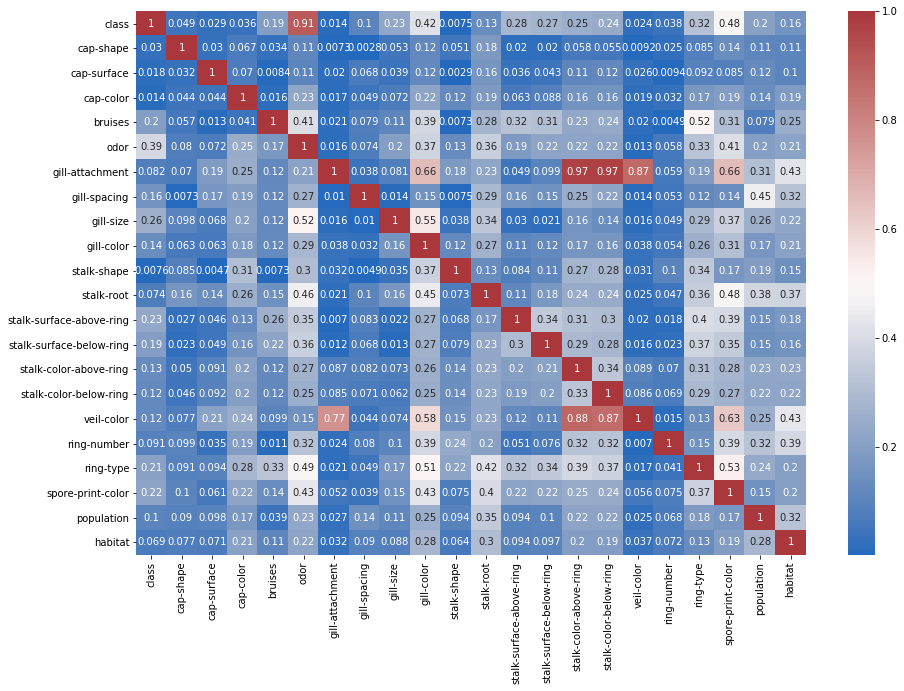

In [20]:
plt.figure(figsize=(15,10))
sns.heatmap(tu, cmap="vlag", annot=True)

In [27]:
df['target'] = np.where(df['class']=='p'
                               ,1
                               ,0)

In [28]:
df.groupby(['odor'])['target'].mean()

odor
a    0.000000
c    1.000000
f    1.000000
l    0.000000
m    1.000000
n    0.034014
p    1.000000
s    1.000000
y    1.000000
Name: target, dtype: float64

In [30]:
model_data.groupby('odor_n').target.mean()

odor_n
0    0.825936
1    0.034014
Name: target, dtype: float64

In [29]:
df.groupby(['gill-size'])['target'].mean()

gill-size
b    0.301497
n    0.885350
Name: target, dtype: float64

Odor looks like it could be a very predictive feature. Gill colour and spore print colour also look promising.

### Prepare Model Data

In [54]:
target = 'target'
features = model_data.drop(columns='target').columns

In [55]:
train, valid = train_test_split(model_data, test_size=0.3, random_state=1, stratify=model_data[target])
valid, test = train_test_split(valid, test_size=0.5, random_state=1, stratify=valid[target])

In [61]:
print(f'train: {len(train)} {train[target].sum()/len(train)}')
print(f'validation: {len(valid)} {valid[target].sum()/len(valid)}')
print(f'test: {len(test)} {test[target].sum()/len(test)}')

train: 5686 0.4820612029546254
validation: 1219 0.4815422477440525
test: 1219 0.48236259228876127


### Model Fit - Decision Tree

In [62]:
clf = tree.DecisionTreeClassifier(max_depth=6, min_samples_leaf=100, random_state=1)

In [63]:
clf = clf.fit(train[features], train[target])

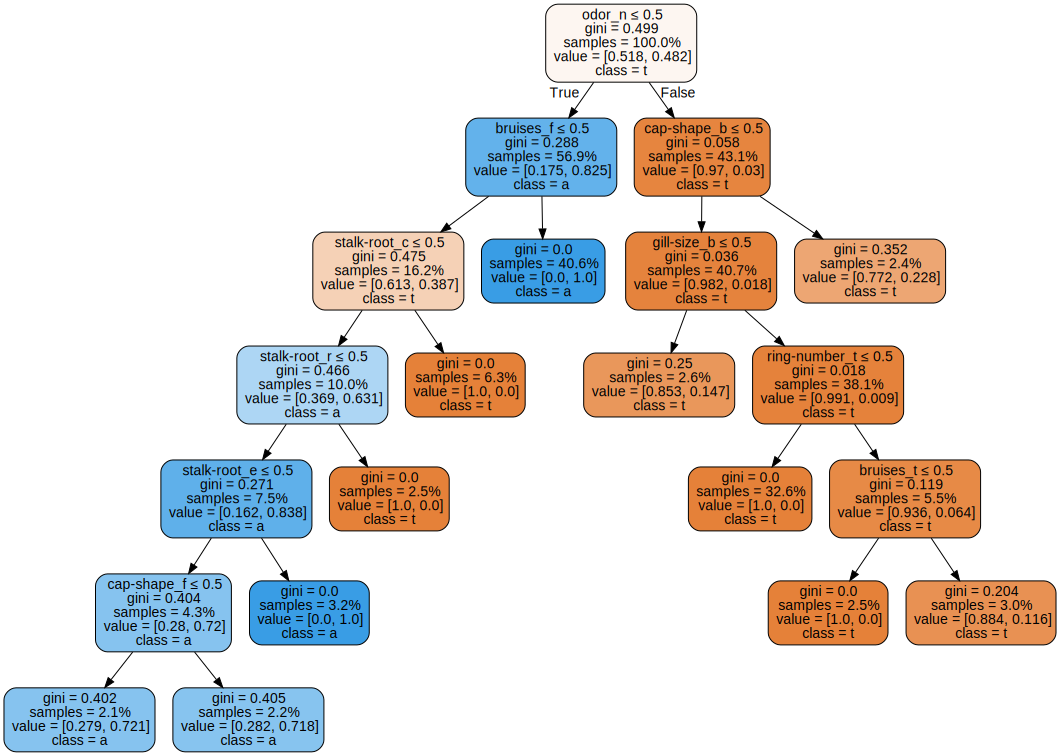

In [65]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=features,  
                      class_names=target,  
                      filled=True, rounded=True,  
                      special_characters=True,
                      proportion=True)  
graph = graphviz.Source(dot_data)  
graph 

In [70]:
valid_y_pred = clf.predict(valid[features])

In [72]:
print("Accuracy:",metrics.accuracy_score(valid[target], valid_y_pred))

Accuracy: 0.9696472518457753


In [73]:
print(metrics.confusion_matrix(valid[target], valid_y_pred))

[[622  10]
 [ 27 560]]


In [75]:
print(metrics.classification_report(valid[target], valid_y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       632
           1       0.98      0.95      0.97       587

    accuracy                           0.97      1219
   macro avg       0.97      0.97      0.97      1219
weighted avg       0.97      0.97      0.97      1219



In [77]:
print('Mean Absolute Error:', metrics.mean_absolute_error(valid[target], valid_y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(valid[target], valid_y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(valid[target], valid_y_pred)))

Mean Absolute Error: 0.030352748154224774
Mean Squared Error: 0.030352748154224774
Root Mean Squared Error: 0.17422040108501866
